## Toy model of correlations with gain variation by row
## Craig Lage - 29Apr20

In [9]:
import os, sys, glob, time, copy
import numpy as np
import matplotlib.pyplot as plt

In [102]:
def buildFlats(nx, ny, numFluxes, flux0, gain0, dgain, mode):
    # Build the flats
    flats = []
    for n in range(numFluxes):
        flux = flux0 * (n + 1)
        for m in range(2):  # Pairs
            arr = np.zeros([nx, ny])
            for j in range(ny):
                if mode == 'Deterministic':
                    gain = gain0 * (1.0 + float(j)/float(ny) * dgain) # Deterministic gain variation
                elif mode == 'Random':
                    gain = gain0 * (1.0 + np.random.rand() * dgain) # Random gain variation
                for i in range(nx):
                    arr[i,j] = np.random.poisson(lam=flux) * gain
            flats.append(arr)
    return flats

In [95]:
# Copied from DM makeBrighterFatterKernel.py 
# but made modifications to eliminate need for DM stack
def crossCorrelate(flat1, flat2, maxLag, border):
    mean = np.mean(flat1[border: -border, border: -border])
    mean += np.mean(flat2[border: -border, border: -border])
    # Diff the images, and apply border
    diff = copy.deepcopy(flat1)
    diff -= flat2
    diff = diff[border: -border, border: -border]

    # Measure the correlations
    dim0 = diff[0: -maxLag,0 : -maxLag]
    dim0 -= np.mean(dim0)
    width, height = dim0.shape
    xcorr = np.zeros((maxLag + 1, maxLag + 1), dtype=np.float64)

    for xlag in range(maxLag + 1):
        for ylag in range(maxLag + 1):
            dim_xy = copy.deepcopy(diff[xlag:xlag + width, ylag: ylag + height])
            #print(xlag, ylag, dim_xy.shape, np.mean(dim_xy))
            dim_xy -= np.mean(dim_xy)
            dim_xy *= dim0
            xcorr[xlag, ylag] = np.mean(dim_xy)

    return xcorr, mean

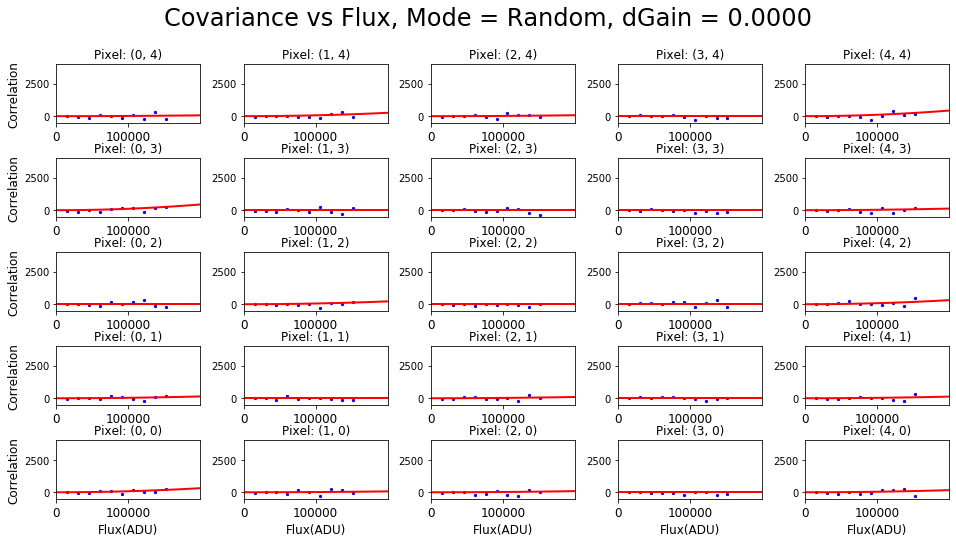

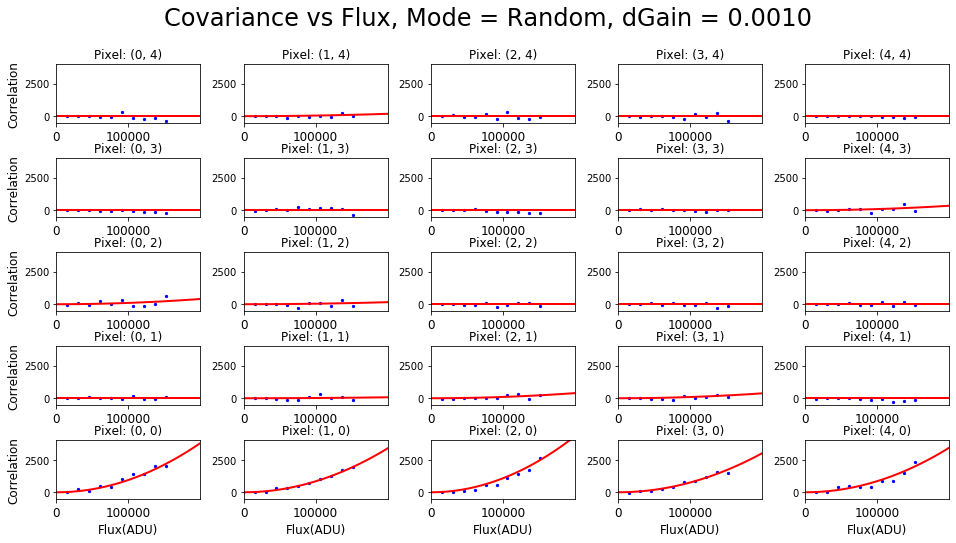

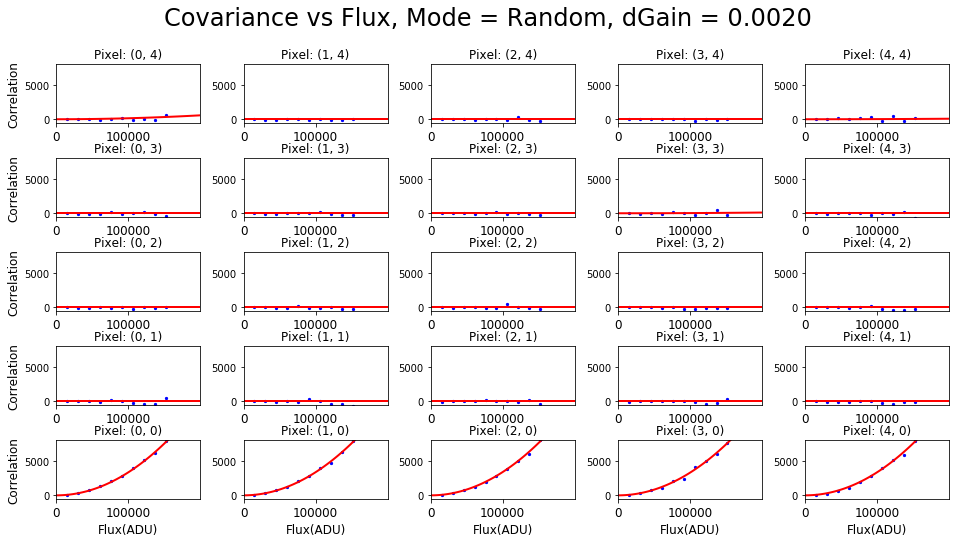

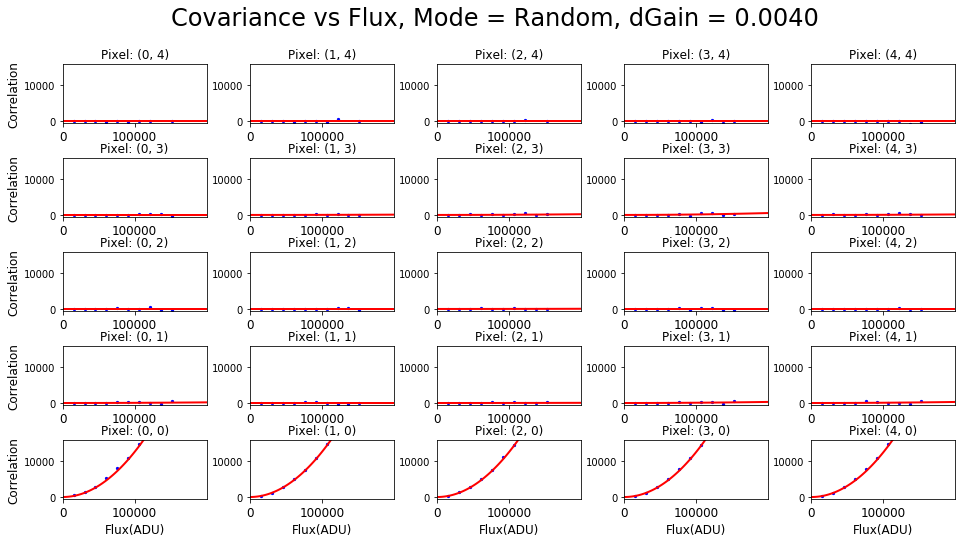

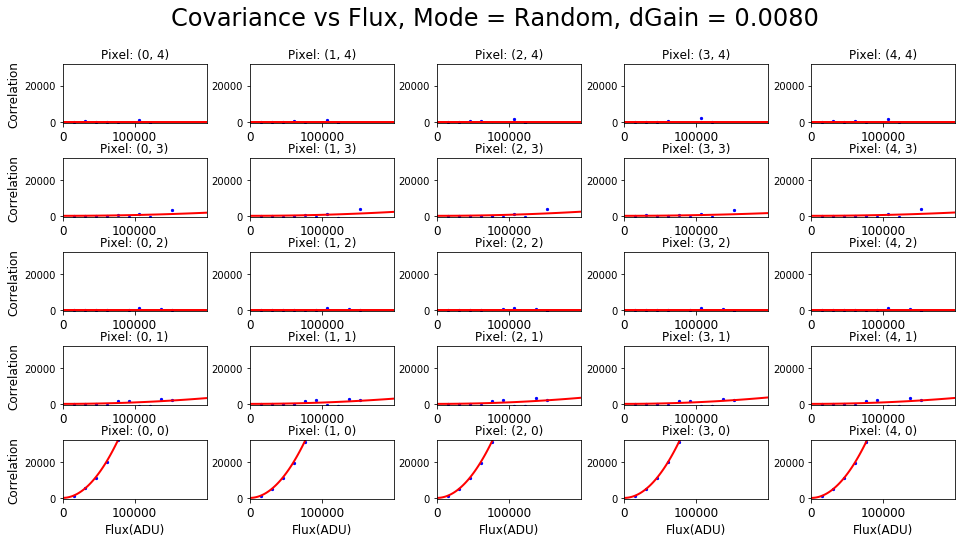

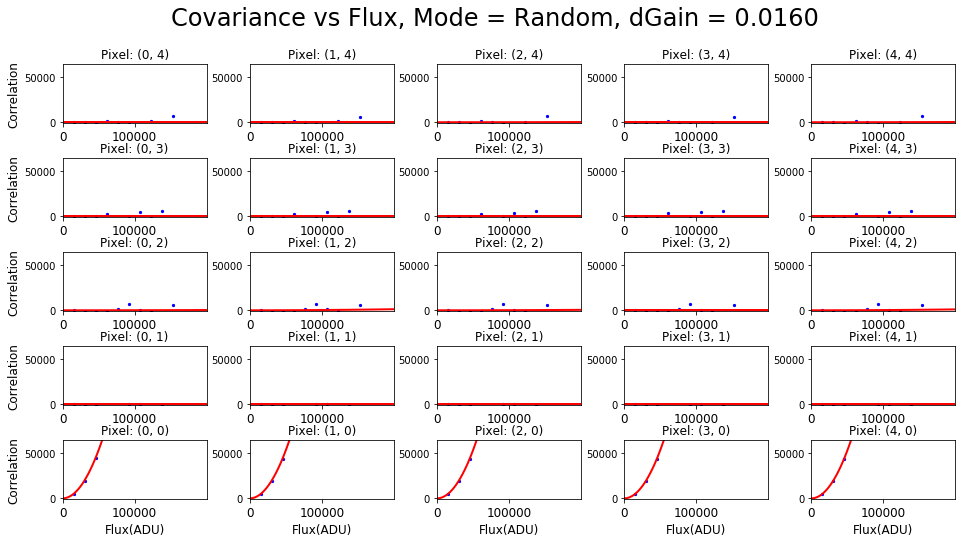

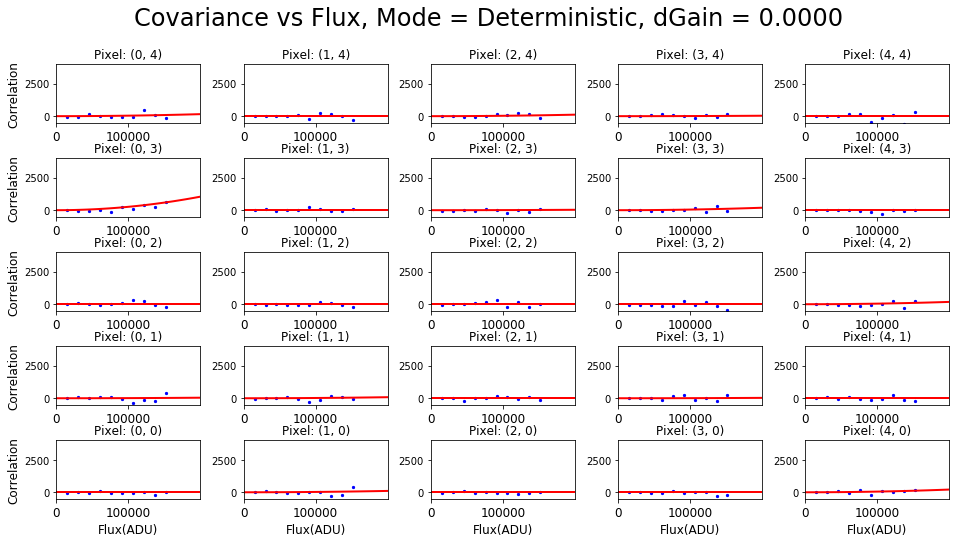

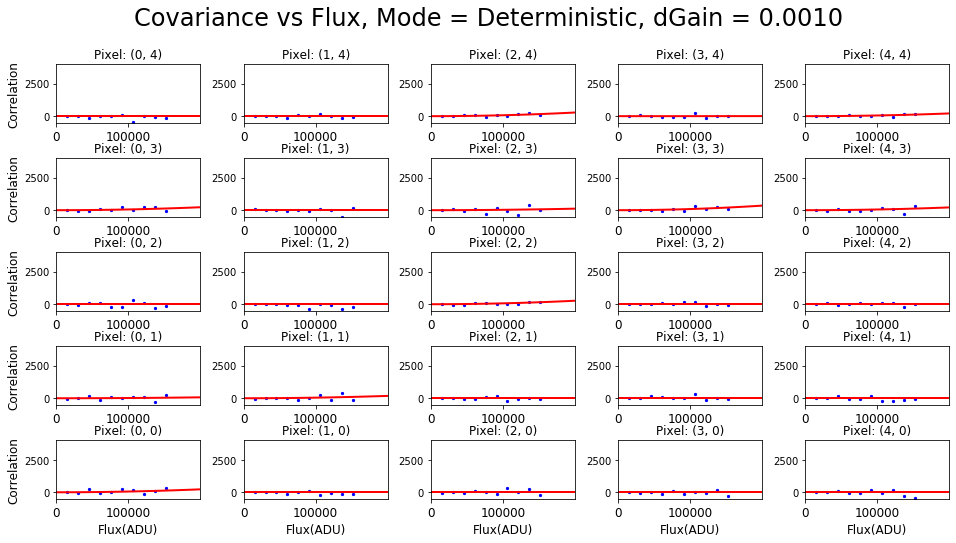

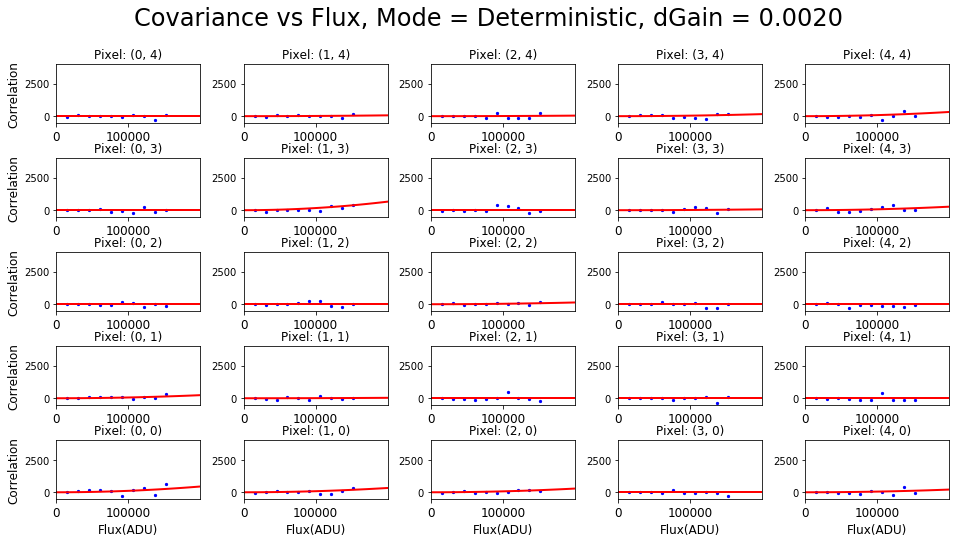

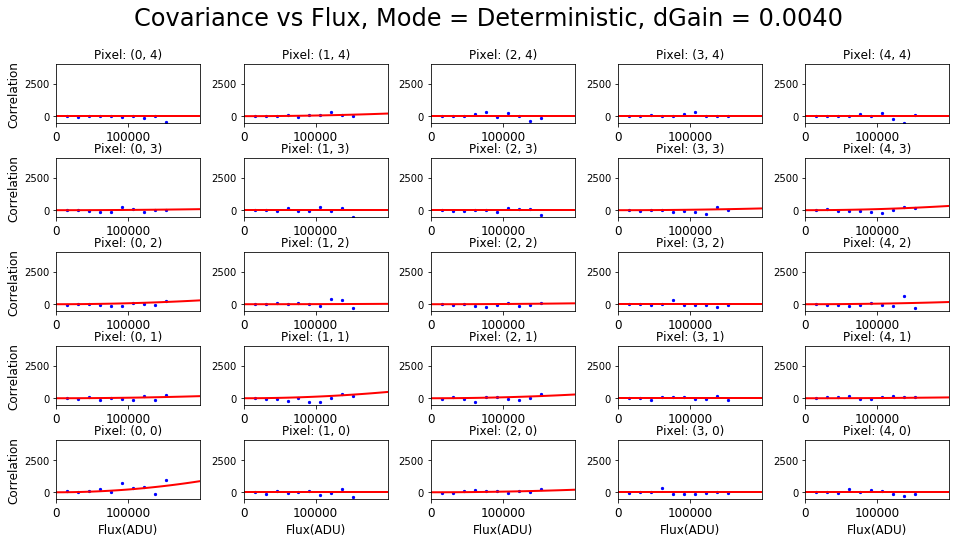

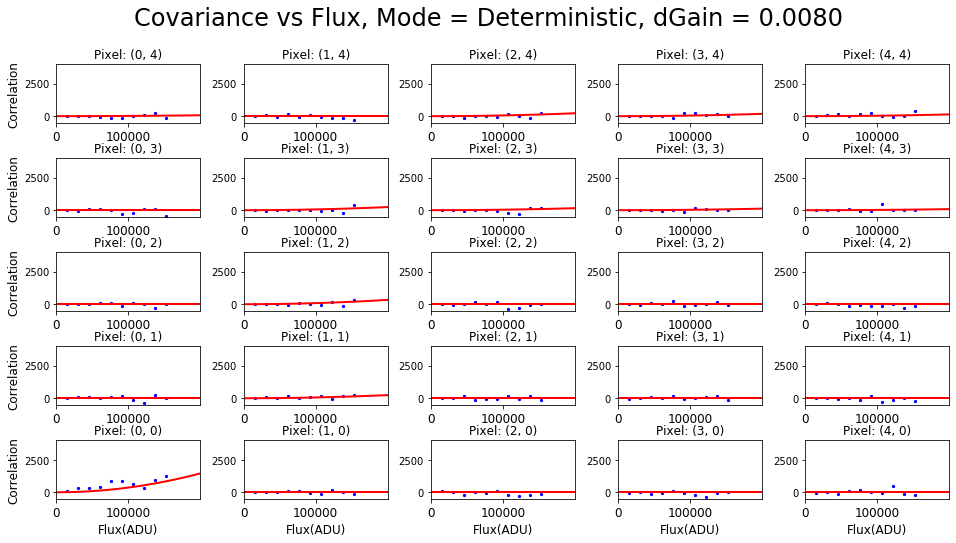

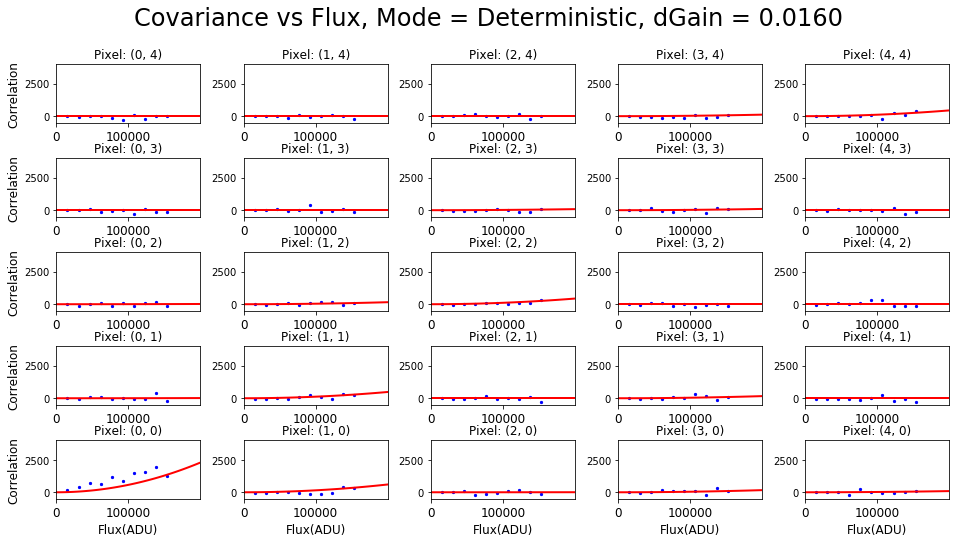

In [113]:
topdir = '/Users/cslage/Research/LSST/code/BOT/R12S02_issue/toy_model/'

nx = 512
ny = 2048
numFluxes = 10
flux0 = 10000
gain0 = 1.52 # Nominal gain
maxLag = 4
border = 10
PlotDelta = maxLag + 1

longRangeCorrs = {} # Dictionary to hold long-range values

dgains = [0.0, 0.001, 0.002, 0.004, 0.008, 0.016]
modes = ['Random', 'Deterministic']
for mode in modes:
    for dgain in dgains:
        key = '%s_%03d'%(mode, int(1000*dgain)) # Dictionary key to hold long range values
        flats = buildFlats(nx, ny, numFluxes, flux0, gain0, dgain, mode)
        xcorrs = []
        means = []
        for n in range(numFluxes):
            xcorr, mean = crossCorrelate(flats[2 * n], flats[2 * n + 1], maxLag, border)
            xcorrs.append(xcorr)
            means.append(mean)
        fig = plt.figure(figsize = (16,8))
        plt.suptitle("Covariance vs Flux, Mode = %s, dGain = %.4f"%(mode, dgain), fontsize = 24)
        plt.subplots_adjust(wspace=0.3, hspace=0.6)
        plotcounter = 0
        lrCorrs = []
        for jj in range(PlotDelta-1, -1, -1):
            for ii in range(PlotDelta):
                plotcounter += 1
                plt.subplot(PlotDelta, PlotDelta, plotcounter)
                cov = []
                flux = []
                for n in range(numFluxes):
                    xcorr = xcorrs[n][ii, jj] / 2.0 
                    mean = means[n] / 2.0
                    if ii == 0 and jj == 0:
                        xcorr -= mean * gain0
                    cov.append(xcorr)
                    flux.append(mean)
                cov = np.array(cov)
                flux = np.array(flux)
                plt.scatter(flux, cov, color='blue', marker='.', s=20)
                coefs = np.polyfit(flux*flux, cov, 1)
                if jj == 0:
                    lrCorrs.append(coefs[0])
                xplot = np.linspace(0,200000, 100)
                yplot = max(0, coefs[0])*xplot*xplot
                plt.plot(xplot,yplot, color = 'red', lw = 2)
                plt.title("Pixel: (%d, %d)"%(ii, jj), fontsize = 12)
                if jj == 0:
                    plt.xlabel("Flux(ADU)", fontsize = 12)
                if ii == 0:
                    plt.ylabel("Correlation", fontsize = 12)
                plt.xlim(0,200000)
                plt.ylim(-500, 4000)
                if mode == 'Random' and dgain > 0.0005:
                    plt.ylim(-500, 4000 * dgain/0.001)
                plt.xticks([0,100000],fontsize = 12)
        longRangeCorrs[key] = lrCorrs
        plt.savefig(topdir+'Covariance_vs_Flux_%s_29Apr20.pdf'%key)


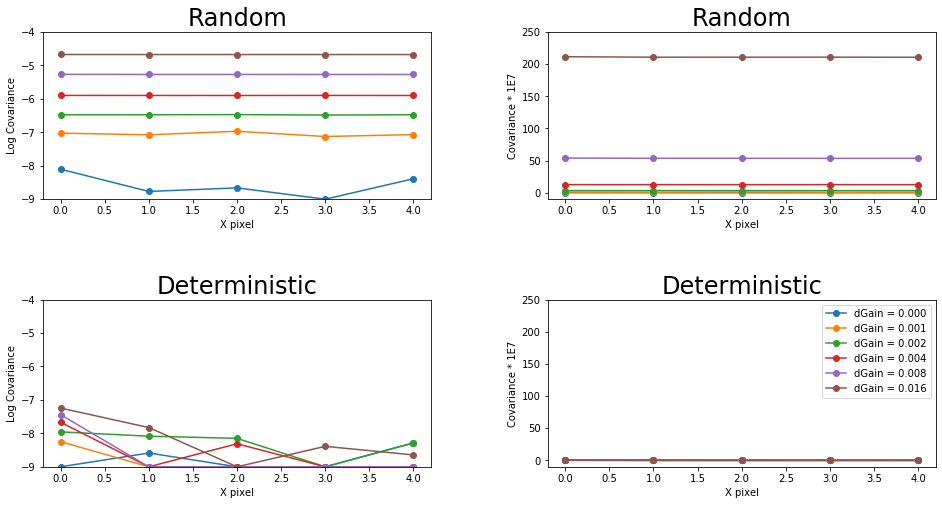

In [131]:
fig = plt.figure(figsize = (16,8))
plt.subplots_adjust(wspace=0.3, hspace=0.6)
plotcounter = 0
for mode in modes:
    for plott in ['Log', 'Linear']:
        plotcounter += 1
        plt.subplot(2,2,plotcounter)
        plt.title(mode, fontsize = 24)
        
        for dgain in dgains:
            xs = []
            ys = []
            key = '%s_%03d'%(mode, int(1000*dgain)) # Dictionary key to hold long range values
            lrCorrs = longRangeCorrs[key]
            for ii in range(PlotDelta):
                xs.append(ii)
                ys.append(max(1.0E-9, lrCorrs[ii]))
            if plott == 'Linear':
                plt.plot(xs, np.array(ys)*1.0E7, marker = 'o', label = 'dGain = %.3f'%dgain)
                plt.ylim(-10,250)
                plt.ylabel('Covariance * 1E7')
                if mode == 'Deterministic':
                    plt.legend()
            else:
                plt.plot(xs, np.log10(ys), marker = 'o', label = 'dGain = %.3f'%dgain)
                plt.ylim(-9.0, -4.0)
                plt.ylabel('Log Covariance')
            plt.xlabel('X pixel')
    
plt.savefig(topdir+'Covariance_vs_dGain_29Apr20.pdf')